In [3]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append(os.path.join(os.getenv("HOME"), "RNN_Manifold/"))
import s1_direct_product_generator, geometry_util, s1_direct_product_dimension_detecting_decoder

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

First, generate some synthetic ring data

In [5]:
encoder, decoder = s1_direct_product_generator.train(1, 12, device, n_training_iterations=3000)
angles = np.arange(start=0, stop=2 * np.pi, step=0.01)
with torch.no_grad():
    points = geometry_util.torch_angles_to_ring(torch.tensor(angles, dtype=torch.get_default_dtype()).to(device))
    points = torch.unsqueeze(points, -2)
    ring_embedded_points = encoder(points)
ring_embedded_points = ring_embedded_points.cpu().numpy()


/home/trevor/brainvenv/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


iteration: 0, decoding loss: 1.0585721731185913, distance cost: 0.003723416943103075
iteration: 1, decoding loss: 0.9985806941986084, distance cost: 0.03511831536889076
iteration: 2, decoding loss: 0.4647623896598816, distance cost: 0.059866566210985184
iteration: 3, decoding loss: 0.3643225133419037, distance cost: 0.08677388727664948
iteration: 4, decoding loss: 0.3187597990036011, distance cost: 0.1276344507932663
iteration: 5, decoding loss: 0.2873629331588745, distance cost: 0.1411076784133911
iteration: 6, decoding loss: 0.26835545897483826, distance cost: 0.14995263516902924
iteration: 7, decoding loss: 0.28280067443847656, distance cost: 0.12105946987867355
iteration: 13, decoding loss: 0.3579474091529846, distance cost: 0.021010318771004677
iteration: 14, decoding loss: 0.28290295600891113, distance cost: 0.01615753024816513
iteration: 15, decoding loss: 0.25906649231910706, distance cost: 0.017814384773373604
iteration: 16, decoding loss: 0.25347036123275757, distance cost: 0

In [6]:
ring_embedded_points = ring_embedded_points/np.mean(np.abs(ring_embedded_points))

Now we will detect the dimension of and decode the ring data we just generated. The below code looks for the best manifold of dimension max_n_dimensions or less and fits it.

In [74]:
import importlib
max_n_dimensions = 4
importlib.reload(s1_direct_product_dimension_detecting_decoder)
encoder, decoder, geometry_profile = s1_direct_product_dimension_detecting_decoder.train(ring_embedded_points, max_n_dimensions, device, decoder_weight=10, scrambling_weight=1, order_red_weight=1, n_training_iterations=15000)


iteration: 0, decoding loss: 1.2728646993637085, distance cost: 0.014003412798047066, order reduction: 0.008830919861793518, scrambling weights: tensor([0.0180, 0.0180, 0.0180, 0.0180], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
iteration: 1, decoding loss: 0.8084068894386292, distance cost: 0.10346602648496628, order reduction: 0.018575528636574745, scrambling weights: tensor([0.0180, 0.0180, 0.0180, 0.0180], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
iteration: 2, decoding loss: 0.7489221096038818, distance cost: 0.011026171036064625, order reduction: 0.003069458995014429, scrambling weights: tensor([0.0180, 0.0180, 0.0180, 0.0180], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
iteration: 3, decoding loss: 0.3067013621330261, distance cost: 0.019526200369000435, order reduction: 0.0035468374844640493, scrambling weights: tensor([0.0180, 0.0180, 0.0180, 0.0180], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
iteration: 5, decoding loss: 0.1141737774014473,

The last return of this function, geometry_profile, contains the optimized value of scrambling_weights. If training worked, this should be close to 1 everywhere except for one index, which should be close to zero. This means the training process identified the fact that the underlying manifold had only one dimension. The index of the near-zero element, the "primary dimension" is the dimension we should use to address the 1D manifold.

In [75]:
geometry_profile = geometry_profile.cpu().detach().numpy()

In [76]:
used_dimension = np.argmin(geometry_profile)
print(used_dimension)

3


If training worked, the encoder should not be sensitive to inputs except for the primary dimension. We can test this.

In [77]:
test_batch_size = 100
all_test_phases = np.random.uniform(-np.pi, np.pi, (test_batch_size, max_n_dimensions))
all_test_phases[:, used_dimension] = np.ones(test_batch_size) * np.random.uniform(-np.pi, np.pi)

In [78]:
with torch.no_grad():
    test_embeddings = encoder(torch.tensor(geometry_util.angles_to_ring(all_test_phases), dtype=torch.get_default_dtype()).to(device)).cpu().numpy()


In [79]:
mean_result = np.mean(test_embeddings, axis=0)
embedding_angle_shifts = np.arccos(np.einsum("j, ij -> i", mean_result, test_embeddings)/(np.sqrt(mean_result.dot(mean_result) * np.einsum("ij, ij -> i", test_embeddings, test_embeddings))))

Text(0, 0.5, 'Counts')

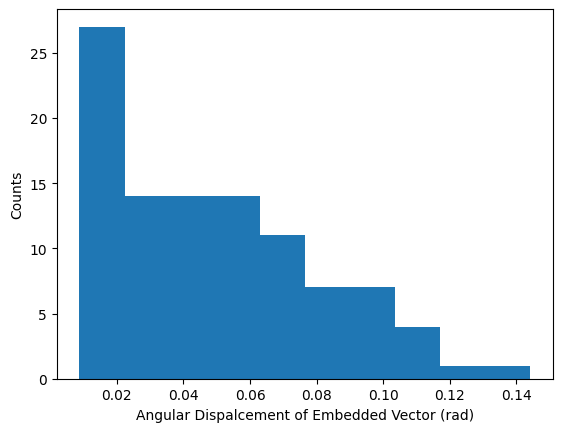

In [80]:
fig, ax = plt.subplots()
ax.hist(embedding_angle_shifts)
ax.set_xlabel("Angular Dispalcement of Embedded Vector (rad)")
ax.set_ylabel("Counts")

We can see that the embedding vector is only displaced slightly when completely random phases are supplied to the non-primary dimensions.

We can also check that the returned decoder produces the right phases compared to ground truth values,

In [81]:
with torch.no_grad():
    decoded_points, decoded_angles = decoder(torch.tensor(ring_embedded_points, dtype=torch.get_default_dtype()).to(device))

predicted_phases = torch.squeeze(decoded_angles).cpu().numpy()[:, used_dimension]


In [82]:
def reference_phases(phases):
    phases_refd = phases - phases[0]
    phases_refd = np.arctan2(np.sin(phases_refd), np.cos(phases_refd))
    return phases_refd * np.sign(phases_refd[int(len(phases)/4)])


In [83]:
def compare_to_ground_truth(predicted_phases, ground_truth_phases, plot_ax):
    refd_test_phases = reference_phases(predicted_phases)
    refd_true_phases = reference_phases(ground_truth_phases)
    line = np.arange(start=-np.pi, stop=np.pi, step=0.01)
    plot_ax.scatter(refd_true_phases, refd_test_phases)
    plot_ax.plot(line, line, color="black", linestyle="--", label="y=x")
    plot_ax.set_xlabel("True Phase")
    plot_ax.set_ylabel("Found Phase")
    return refd_test_phases, refd_true_phases


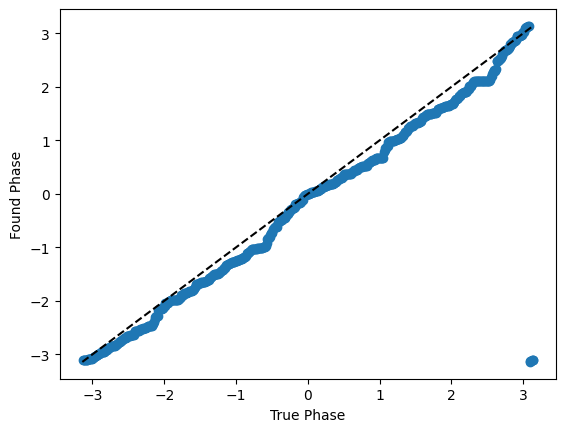

In [84]:
%matplotlib inline
fig, ax = plt.subplots()
refd_predicted_phases, refd_true_phases = compare_to_ground_truth(predicted_phases, angles, ax)
